In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Creating a dataset of filtered images
These images are filtered to toggle different views of the land. This filter is looking for the edges to determine dimensions of farmland. The images can be clustered. The clusters can have samples taken and be visually inspected to classify them as profitable, somewhat profitable, not profitable, etc. Those labels can then be encoded (with 0 being not profitable and 5 being most profitable) and used as features in other models.

Fine-tuning the kernel filters to different levels can potentially help see other variables in the land. Direct analysis would again be needed to label clusters based on samples pulled from each cluster and those labels can become features in larger models as well.

In [67]:
#setting the path to the directory containing the pics
path = './sample_images/'

#appending the pics to the training data list
training_data = []

for img in os.listdir(path):
    if img.endswith('.png'):
        pic = cv2.imread(os.path.join(path,img))
        #pic = cv2.resize(pic,(80,80))
        pic = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        #kernel = np.array([[-1,-1,-1], [2,2,2], [-0.75,-0.75,-0.75]]) ######################################
        kernel = np.array([[-1,-1,-1], [2,2,2], [-0.15,-0.15,-0.15]]) #####################################
        pic = cv2.filter2D(pic, -1, kernel)
        pic = cv2.resize(pic,(200,200))
        training_data.append([pic])
    else:
        pass

#converting the list to numpy array and saving it to a file using #numpy.save
np.save(os.path.join(path+'features/','filtered_images'),np.array(training_data))

#loading the saved file once again
saved_filtered_images = np.load(os.path.join(path+'features/','filtered_images.npy'))

# Creating a dataset of the original images
We need this to compare the filters to the original image and decide if we like the filters applied.

In [36]:
original_data = []

for img in os.listdir(path):
    if img.endswith('.png'):
        image = mpimg.imread(img)
        original_data.append(image)
    else:
        pass

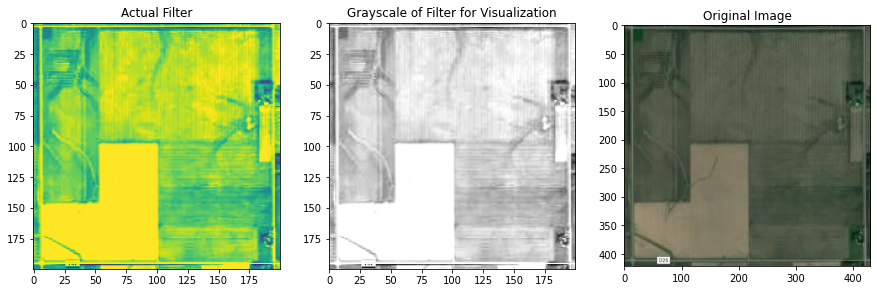

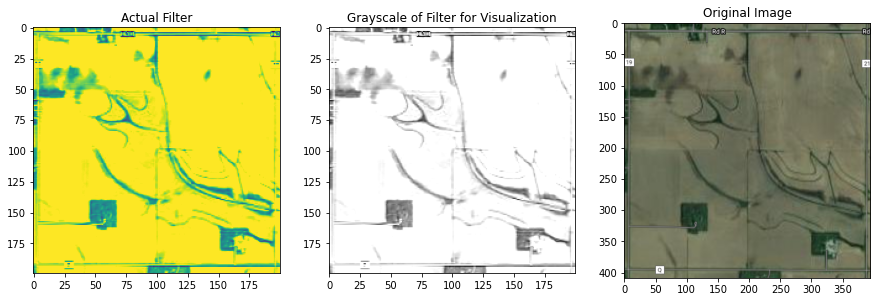

In [69]:
first_n_images = 2
#for i in np.arange(0,first_n_images):

for i in np.arange(0,len(training_data)):
    fig, ax = plt.subplots(1,3, figsize = (15,7))
    ax[0].set_title('Actual Filter')
    ax[0].imshow(np.array(saved_filtered_images[i]).reshape(200,200))
    ax[1].set_title('Grayscale of Filter for Visualization')
    ax[1].imshow(np.array(saved_filtered_images[i]).reshape(200,200), cmap='gray')
    ax[2].set_title('Original Image')
    ax[2].imshow(np.array(original_data[i]));

# Data Normalization
We need to normalize the images between 0 and 1 so the model converges and does not assign similar labels to noise structures. 0 and 1 is chosen because the model runs quickly on this scale.

Because the max value of image values is 255 and the starting point is 0, I divide the values by 255 to get to a max of 1.

In [72]:
print("Min value of image dataset: %d\nMax value of image dataset %d"%(saved_filtered_images.min(), saved_filtered_images.max()))

Min value of image dataset: 0
Max value of image dataset 255


In [70]:
x_train = saved_filtered_images.astype('float32')
x_train_normalized = x_train/255.0

In [75]:
print("Min value of normalized image dataset: %d\nMax value of normalized image dataset %d"%(x_train_normalized.min(), x_train_normalized.max()))

Min value of normalized image dataset: 0
Max value of normalized image dataset 1


# Reshaping Input Data
That needs to be changed to (N,(xy)), where xy = x*y; 2D is required. The first time I did this, I set the images to be 200x200 pixles on a test dataset of 2. Therefore, the new normalized dimension will be (2,40000). With N images, the result would be (N, 40000):

In [77]:
X_train = x_train.reshape(len(x_train_normalized),-1)

In [87]:
print("Shape of the data is: {}".format(X_train.shape))
print("This is because there are {} images, each with pixle size {} by {}".format(X_train.shape[0], int(np.sqrt(40000)), int(np.sqrt(40000))))

Shape of the data is: (2, 40000)
This is because there are 2 images, each with pixle size 200 by 200


# Clustering Algorithm: Mini-Batch K-Means
The difference between mini-batch K-Means and regular K-Means is that in mini-batch reduces computational expense by randomly sampling from the population. If there is a high volume of data, mini-batch would be useful. If not - or if computational resource is not an issue - use regular K-Means instead. Finding convergence may or may not be worth the expense.

This is pulled from <https://medium.com/@joel_34096/k-means-clustering-for-image-classification-a648f28bdc47>

In [90]:
from sklearn.cluster import MiniBatchKMeans

number_of_desired_classifications = 6 # a scale of land profitability ratings between 0 and 5

total_clusters = number_of_desired_classifications

# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters)
# Fitting the model to training set
kmeans.fit(X_train)

MiniBatchKMeans(n_clusters=2)

In [91]:
kmeans.labels_

array([1, 0], dtype=int32)

In [96]:
def retrieve_info(cluster_labels,y_train):
    '''
     Associates most probable label with each cluster in KMeans model
     returns: dictionary of clusters assigned to each label
    '''
    # Initializing
    reference_labels = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

# If you have the labels, this validates the clustering against them.
Typically, you don't have labels when you cluster. That's the point of unsupervised learning so it's ok if you don't have labels

In [ ]:
reference_labels = retrieve_info(kmeans.labels_, )
print(reference_labels)

In [ ]:
reference_labels = retrieve_info(kmeans.labels_,y_train)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

In [ ]:
# Comparing Predicted values and Actual values
print(number_labels[:20].astype(‘int’))
print(y_train[:20])

In [ ]:
# Calculating accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(number_labels,y_train))

In [ ]:
# Function to calculate metrics for the model
def calculate_metrics(model,output):
    print("Number of clusters is {}".format(model.n_clusters))
    print("Inertia: {}".format(model.inertia_))
    print("Homogeneity:       {}".format(metrics.homogeneity_score(output,model.labels_)))

In [ ]:
from sklearn import metrics
cluster_number = [10,16,36,64,144,256]
for i in cluster_number:
total_clusters = len(np.unique(y_test))
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = i)
# Fitting the model to training set
kmeans.fit(X_train)
# Calculating the metrics
 
calculate_metrics(kmeans,y_train)
# Calculating reference_labels
reference_labels = retrieve_info(kmeans.labels_,y_train)
# ‘number_labels’ is a list which denotes the number displayed in image
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

print("Accuracy score: {}".format(accuracy_score(number_labels,y_train)))
print("\n")

In [ ]:
# Testing model on Testing set
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = 256)
# Fitting the model to testing set
kmeans.fit(X_test)
# Calculating the metrics
calculate_metrics(kmeans,y_test)
# Calculating the reference_labels
reference_labels = retrieve_info(kmeans.labels_,y_test)
# ‘number_labels’ is a list which denotes the number displayed in image
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

print("Accuracy score: {}".format(accuracy_score(number_labels,y_test)))
print("\n")

# Visualize Cluster Centroids

In [ ]:
# Cluster centroids is stored in ‘centroids’
centroids = kmeans.cluster_centers_

In [ ]:
centroids.shape

In [ ]:
centroids = centroids.reshape(256,200,200) # (cluster_count, pixle dim 1, pixle dim 2)

In [ ]:
# Earlier on (above), the max value was 255, which we used for normalizing so here we multiply by 255 to un-transform the normalized values
centroids = centroids * 255

In [ ]:
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.title(‘Number:{}’.format(reference_labels[i]),fontsize = 17)
    plt.imshow(centroids[i])

In [ ]:
# Reading the image
image = plt.imread(‘number_4.jpg’)
plt.imshow(image)

In [ ]:
image.shape

In [ ]:
# RGB image is converted to Monochrome image
from skimage import color
from skimage import io
image = color.rgb2gray(io.imread(‘number_4.jpg’))

In [ ]:
# Reshaping into a row vector
image = image.reshape(1,28*28)

In [ ]:
# Importing the dataset from keras
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
print(x_train.min())
print(x_train.max())
print(image.min())
print(image.max())

In [ ]:
# Normalization of ‘x_train’
x_train = x_train.astype(‘float32’)
x_train = x_train/255.0

In [ ]:
# Reshaping of ‘x_train’
x_train = x_train.reshape(60000,28*28)

In [ ]:
# Training the model
kmeans = MiniBatchKMeans(n_clusters=256)
kmeans.fit(x_train)

In [ ]:
reference_labels = retrieve_info(kmeans.labels_,y_train)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

In [ ]:
predicted_cluster = kmeans.predict(image)

In [ ]:
number_labels[[predicted_cluster]]